# Load and process HAM 10000 data

files.upload returns a dictionary of the files which were uploaded. The dictionary is keyed by the file name and values are the data which were uploaded. 

*I will try to use this to upload my HAM100000 data to Google Drive and access it in my notebook here.*


## Installations before we start

In [2]:
# update pytorch and fastai to latest versions
!pip install torch -U
!pip install torchvision -U
!pip install fastai -U 
!pip install -q kaggle

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.60)


In [3]:
# import the usual frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings
import json
import os

from IPython.core.display import display, HTML
    
# import plotly 
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls

# for color scales in plotly
import colorlover as cl 

# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

from sklearn.metrics import auc, roc_curve, roc_auc_score

# configure things
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format  
pd.options.display.max_columns = 999

py.init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Setting up the Kaggle API

In [4]:
# mount your google drive so you can save to it. You'll need to put in a token.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"christinasalker","key":"cdc5bf5974a8aac9875438827e7bccd2"}'}

In [0]:
# create environment variables for kaggle to authenticate with
os.environ['KAGGLE_USERNAME'] = "christinasalker"
os.environ['KAGGLE_KEY'] = "cdc5bf5974a8aac9875438827e7bccd2"

In [7]:
##os.mkdir('c_skin')
os.listdir()

['.config', 'kaggle.json', 'gdrive', 'sample_data']

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

## Loading the HAM10000 dataset

In [9]:
# get the dataset from kaggle
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p 'c_skin'

100% 5.19G/5.20G [01:12<00:00, 35.2MB/s]
100% 5.20G/5.20G [01:13<00:00, 76.5MB/s]


In [10]:
! kaggle datasets list

ref                                                        title                                                size  lastUpdated          downloadCount  
---------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
jessemostipak/hotel-booking-demand                         Hotel booking demand                                  1MB  2020-02-13 01:27:20           5057  
tunguz/big-five-personality-test                           Big Five Personality Test                           159MB  2020-02-17 15:59:37           1395  
arindam235/startup-investments-crunchbase                  StartUp Investments (Crunchbase)                      3MB  2020-02-17 21:54:42           1241  
jamzing/sars-coronavirus-accession                         SARS CORONAVIRUS ACCESSION                            2MB  2020-02-18 15:49:34           1678  
brandenciranni/democratic-debate-transcripts-2020          Democratic 

In [15]:
# Unzip the whole zipfile into /c_skin
!unzip -o c_skin/skin-cancer-mnist-ham10000.zip -d c_skin

# Quietly unzip the image files
#!unzip -o -q c_skin/HAM10000_images_part_1 -d c_skin
#!unzip -o -q c_skin/HAM10000_images_part_2 -d c_skin

# Tell me how many files I unzipped///
!echo files in c_skin: `ls c_skin | wc -l`

Streaming output truncated to the last 5000 lines.
  inflating: c_skin/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: c_skin/ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: c_skin

In [16]:
!ls c_skin

ham10000_images_part_1	HAM10000_metadata.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_1	hmnist_28_28_L.csv     skin-cancer-mnist-ham10000.zip
ham10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_2	hmnist_8_8_L.csv


## Load data into pandas df

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob

In [0]:
base_skin_dir = os.path.join('c_skin')

In [0]:
# This os.path method does not really work, because the files are not local
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [0]:
# Create dictionary of the different lesion types
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [39]:
tile_df = pd.read_csv('c_skin/HAM10000_metadata.csv')
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.00,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.00,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.00,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.00,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.00,male,ear


In [40]:
tile_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [41]:
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
3429,HAM_0001140,ISIC_0024884,nv,follow_up,55.00,male,back,c_skin/HAM10000_images_part_1/ISIC_0024884.jpg
6331,HAM_0007457,ISIC_0029813,nv,follow_up,35.00,female,lower extremity,c_skin/ham10000_images_part_2/ISIC_0029813.jpg
8380,HAM_0000211,ISIC_0029609,nv,histo,35.00,female,upper extremity,c_skin/ham10000_images_part_2/ISIC_0029609.jpg
3097,HAM_0002545,ISIC_0029149,nv,follow_up,45.00,female,lower extremity,c_skin/HAM10000_images_part_1/ISIC_0029149.jpg
4294,HAM_0004236,ISIC_0032180,nv,follow_up,55.00,female,back,c_skin/ham10000_images_part_2/ISIC_0032180.jpg


In [42]:
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
5275,HAM_0004597,ISIC_0027050,nv,follow_up,40.00,male,upper extremity,c_skin/HAM10000_images_part_1/ISIC_0027050.jpg,Melanocytic nevi,4
3052,HAM_0001061,ISIC_0029526,nv,follow_up,45.00,male,back,c_skin/ham10000_images_part_2/ISIC_0029526.jpg,Melanocytic nevi,4
6534,HAM_0001946,ISIC_0029333,nv,follow_up,40.00,male,trunk,c_skin/ham10000_images_part_2/ISIC_0029333.jpg,Melanocytic nevi,4
6364,HAM_0000786,ISIC_0028956,nv,follow_up,30.00,female,trunk,c_skin/HAM10000_images_part_1/ISIC_0028956.jpg,Melanocytic nevi,4
2714,HAM_0000953,ISIC_0026213,bcc,histo,70.00,male,chest,c_skin/HAM10000_images_part_1/ISIC_0026213.jpg,Basal cell carcinoma,1


In [43]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0026361,nv,histo,male,back,c_skin/HAM10000_images_part_1/ISIC_0025191.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


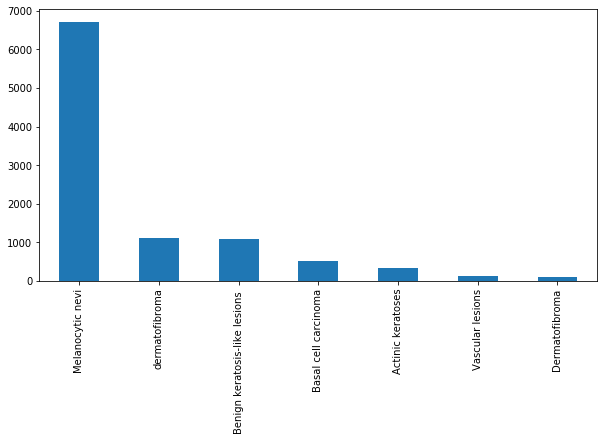

In [45]:
# Using matplotlib to visualize the number of images per lesion type
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [0]:
# Load all the images into the df
from skimage.io import imread
tile_df['image'] = tile_df['path'].map(imread)

In [47]:
# See the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

## Show images in each category

In [48]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

## Make an EMNIST Like Dataset

In [49]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
2370,5,Vascular lesions
1577,6,dermatofibroma


Create a df with only the image(pixel) and the lable. The emnist data set in the federated example has the following `element_type_structure`

OrderedDict([('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None)), ('label', TensorSpec(shape=(), dtype=tf.int32, name=None))])

In [52]:
federated_df = tile_df[['image','cell_type_idx']]
federated_df.head()

,image,cell_type_idx
0,"[[[188, 147, 191], [186, 148, 189], [187, 150,...",2
1,"[[[25, 15, 23], [25, 14, 22], [25, 14, 22], [2...",2
2,"[[[186, 128, 140], [188, 128, 136], [183, 126,...",2
3,"[[[24, 9, 16], [22, 11, 15], [23, 11, 15], [26...",2
4,"[[[122, 80, 102], [124, 82, 104], [127, 83, 10...",2
